<a href="https://colab.research.google.com/github/daaaanish17/Image-Classification/blob/main/Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Animal Classification using Transfer Learning Model (MobileNetV2)*

Connect colab runtime to GPU

Importing Libraries

In [1]:
import os
import tensorflow as tf
import numpy as np
from google.colab import drive
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, GlobalAvgPool2D, Input
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

Connecting to Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping image folder

!unzip /content/drive/MyDrive/animal.zip

unzip:  cannot find or open /content/drive/MyDrive/animal.zip, /content/drive/MyDrive/animal.zip.zip or /content/drive/MyDrive/animal.zip.ZIP.


Using Python Dictionary present in animal_classification folder for renaming folders

In [ ]:
from translate import translate

translate

<module 'translate.translate' from '/usr/local/lib/python3.10/dist-packages/translate/translate.py'>

In [ ]:
!unzip /content/animal.zip

Archive:  /content/animal.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/animal.zip or
        /content/animal.zip.zip, and cannot find /content/animal.zip.ZIP, period.


Renaming folder names

In [ ]:
for i in os.listdir('raw-img'):
  os.rename('raw-img/' + i, 'raw-img/' + translate[i])



FileNotFoundError: ignored

Displaying folder names

In [ ]:
for i in os.listdir('raw-img'):
  print(i)

sheep
butterfly
cat
squirrel
chicken
dog
elephant
horse
cow
spider


Displaying No. of Images in each folder

In [ ]:
for i in os.listdir('raw-img'):
  print(i, len(os.listdir('raw-img/' + i)))

sheep 1820
butterfly 2112
cat 1668
squirrel 1862
chicken 3098
dog 4863
elephant 1446
horse 2623
cow 1866
spider 4821


Creating new directories

And Entering data in new directories

In [ ]:
os.mkdir('train')
os.mkdir('test')

for i in os.listdir('raw-img'):
  os.mkdir('train/' + i)
  os.mkdir('test/' + i)

  for j in os.listdir('raw-img/'+i)[:1000]:
    os.rename('raw-img/'+i+'/'+j, 'train/'+i+'/'+j)
  for j in os.listdir('raw-img/'+i)[:400]:
    os.rename('raw-img/'+i+'/'+j, 'test/'+i+'/'+j)

  #train dataset contains 1000 images while test dataset contains 400 images

Creating function for Image Data Generator.

In [ ]:
def img_data(dir_path, target_size, batch, class_lst, pre_processs):
  if pre_processs:
    generate_object = ImageDataGenerator(preprocessing_function=pre_processs)
  else:
    generate_object = ImageDataGenerator()

  return (generate_object.flow_from_directory(dir_path, target_size=target_size, batch_size=batch,  #using flow_from_directory because all of our data is saved in form of directories.
                                              class_mode='sparse', classes=class_lst, shuffle=True))

In [ ]:
train_data_gen = img_data('train', (224, 224), 500, os.listdir('train'), preprocess_input)
# mobilenet. preprocess_input will scale input pixels between -1 and 1. input_shape: Optional shape tuple,
# only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
# (with channels_last data format) or (3, 224, 224) (with channels_first data format).

valid_data_gen = img_data('test', (224, 224), 500, os.listdir('test'), preprocess_input)

Found 10000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


Transfer Learning With MobileNet V2. MobileNet V2 model was developed at Google, pre-trained on the ImageNet dataset with 1.4M images and 1000 classes of web images. *We will use this as our base model* to train with our dataset and classify the images of animals

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)

9406464/9406464 [==============================] - 1s 0us/step


Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
base_model.trainable=False

Creating our Image Classification Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(GlobalAvgPool2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# This callback will stop the training when there is no improvement in # the loss for three consecutive epochs.

elst = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [ ]:

# ModelCheckpoint callback allows you to continually save the model both during and at the end of training.
# Model will saved in our drive ('MyDrive/animal_classification')

save_ck = callbacks.ModelCheckpoint('/content/mdl_wti.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
model.fit(train_data_gen, batch_size=500, validation_data=valid_data_gen, callbacks=[elst, save_ck], epochs=10)

Epoch 1/10
20/20 [==============================] - 51s 2s/step - loss: 0.4887 - accuracy: 0.8460 - val_loss: 0.1951 - val_accuracy: 0.9415
Epoch 2/10
20/20 [==============================] - 55s 3s/step - loss: 0.1368 - accuracy: 0.9564 - val_loss: 0.1637 - val_accuracy: 0.9520
Epoch 3/10
20/20 [==============================] - 46s 2s/step - loss: 0.0895 - accuracy: 0.9738 - val_loss: 0.1516 - val_accuracy: 0.9557
Epoch 4/10
20/20 [==============================] - 56s 3s/step - loss: 0.0627 - accuracy: 0.9845 - val_loss: 0.1552 - val_accuracy: 0.9550
Epoch 5/10
20/20 [==============================] - 58s 3s/step - loss: 0.0463 - accuracy: 0.9895 - val_loss: 0.1721 - val_accuracy: 0.9510
Epoch 6/10
20/20 [==============================] - 46s 2s/step - loss: 0.0356 - accuracy: 0.9913 - val_loss: 0.1535 - val_accuracy: 0.9565
Epoch 7/10
20/20 [==============================] - 45s 2s/step - loss: 0.0242 - accuracy: 0.9959 - val_loss: 0.1564 - val_accuracy: 0.9575
Epoch 8/10
20/20 [==

#Testing using random images

1/1 [==============================] - 1s 1s/step


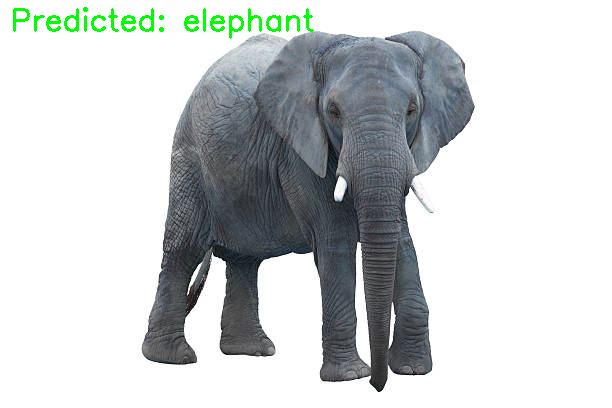

1/1 [==============================] - 0s 43ms/step


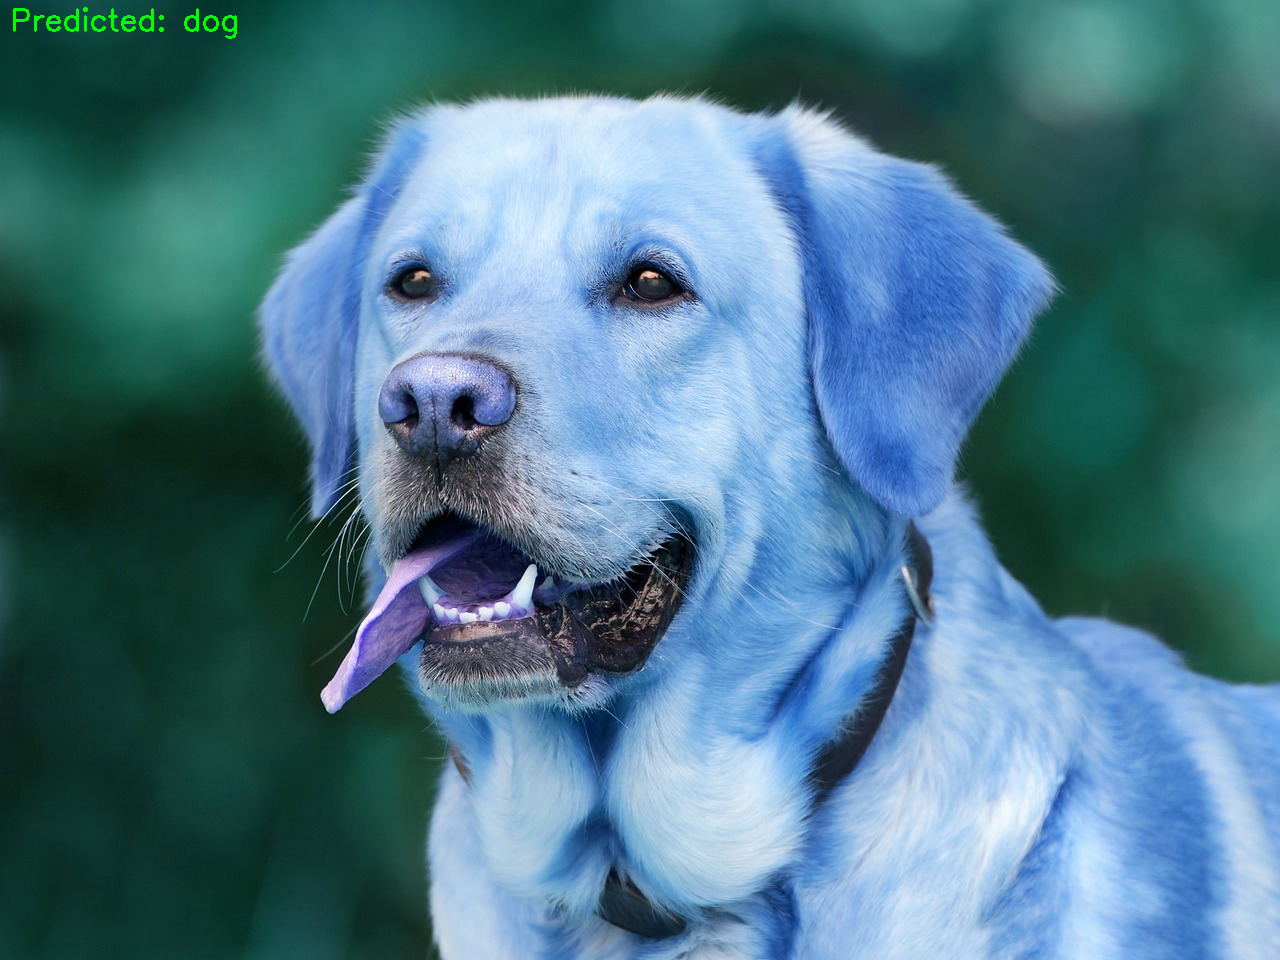

1/1 [==============================] - 0s 40ms/step


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_v2_preprocess_input
from google.colab.patches import cv2_imshow
# Load the pre-trained model
model = tf.keras.models.load_model("/content/mdl_wti.hdf5")

# Dictionary mapping indices to class labels
map_dict = {0: 'sheep', 1: 'butterfly', 2: 'cat', 3: 'squirrel', 4: 'Chicken', 5: 'dog', 6: 'elephant', 7: 'horse', 8: 'cow', 9: 'spider'}

# List of image paths
image_paths = ["/content/istockphoto-94464726-612x612.jpg", "/content/labrador-retriever-1210559_1280.jpg"]  # Add more image paths

for image_path in image_paths:
    opencv_image = cv2.imread(image_path)
    opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(opencv_image, (224, 224))
    resized = mobilenet_v2_preprocess_input(resized)
    img_reshape = resized[np.newaxis, ...]

    # Perform inference
    prediction = model.predict(img_reshape).argmax()
    predicted_label = map_dict[prediction]

    # Display the image with the predicted label
    cv2.putText(opencv_image, f"Predicted: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(opencv_image)
    cv2.waitKey(0)  # Wait for a key press to move to the next image

cv2.destroyAllWindows()

